# Chapter 5. 정규선형모델

## 5.3. 독립변수가 여럿인 모델

* 매상 예측모델
    - 독립변수(x): 습도, 기온, 날씨(맑음 or 비), 가격
    
    
    
* 여러 개의 변수가 있을 때에, 모든 변수들이 유의미할까?



### 5.3.1 분석준비

In [1]:
# 수치 계산에 사용하는 라이브러리
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 그래프를 그리기 위한 라이브러리
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# 통계모델을 추정하는 데 사용하는 라이브러리
import statsmodels.formula.api as smf
import statsmodels.api as sm

# 표시자릿수 지정
%precision 3
# 그래프를 주피터 노트북에 그리기 위한 설정
%matplotlib inline

In [2]:
# 데이터 로드(어느 가게의 매상데이터)
sales = pd.read_csv("5-3-1-lm-model.csv")
print(sales.head(3))

   humidity  price  sales  temperature weather
0      29.5    290  229.7         17.8   rainy
1      38.1    290  206.1         26.1   rainy
2      31.5    290  202.5         22.0   rainy


### 5.3.2 데이터로 그래프 그리기

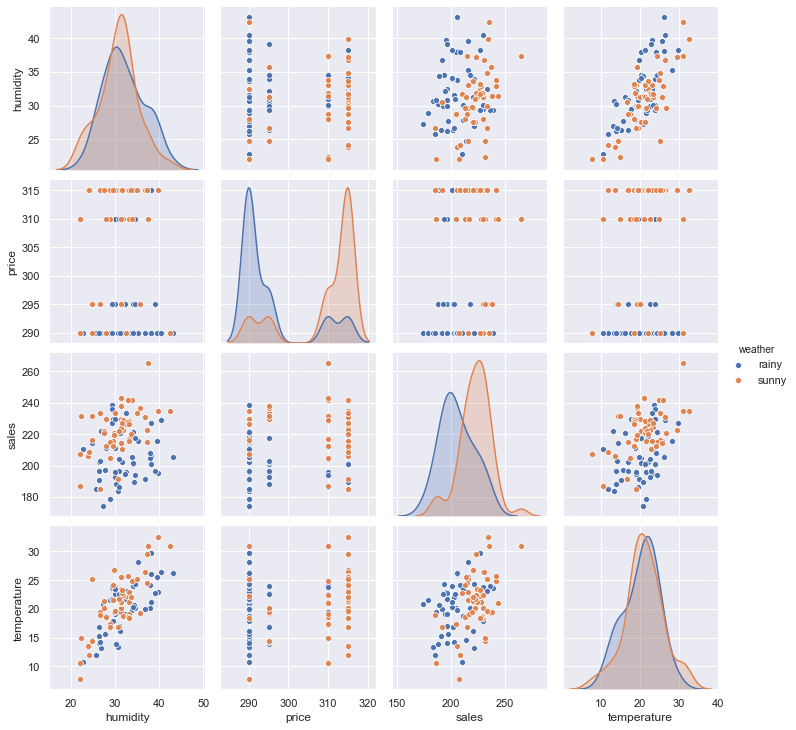

In [3]:
# 독립변수가 여러개 있으므로, 페어플롯을 그려봄
sns.pairplot(data = sales, hue = "weather")

### 5.3.3 나쁜 분석 예: 변수가 1개인 모델 만들기

In [4]:
# 독립변수에 가격만 사용한 단순회귀모델
lm_dame = smf.ols("sales ~ price", sales).fit()
lm_dame.params

Intercept    113.645406
price          0.332812
dtype: float64

In [5]:
# 분산분석을 사용해서 검정
print(sm.stats.anova_lm(lm_dame, typ=2))

                sum_sq    df         F    PR(>F)
price      1398.392322   1.0  4.970685  0.028064
Residual  27570.133578  98.0       NaN       NaN


[분석 결과]

p value가 0.05보다 작게 나옴  

→ 가격이 오르면 매상도 증가한다

→ 매상을 늘리고 싶다면, 가격을 올리면 된다!

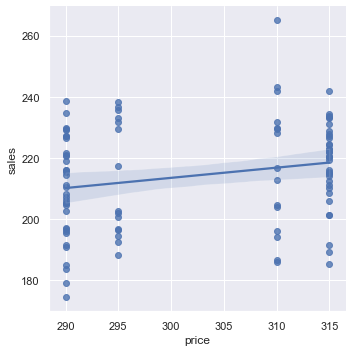

In [6]:
# 회귀 직선
sns.lmplot(x = "price", y = "sales", data = sales)

### 5.3.4 독립변수 간의 관계 조사하기

In [7]:
# 날씨별 평균값
print(sales.groupby("weather").mean())

         humidity  price    sales  temperature
weather                                       
rainy      32.126  295.5  205.924       20.422
sunny      30.852  309.5  222.718       21.102


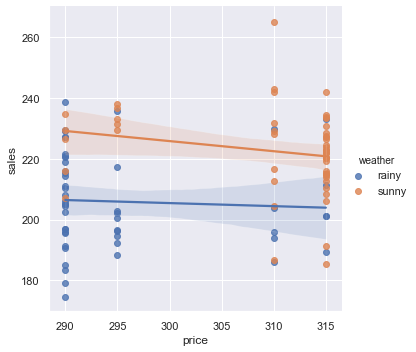

In [8]:
# 날씨가 같을 떄, 상품 가격이 매상에 미치는 영향
sns.lmplot(x = "price", y = "sales", data = sales, 
           hue="weather")

[분석 결과]

* 맑은 날에 매상이 높다

* 날씨별로 분리해서 살펴봤을 때, 가격이 높아지면 매상이 줄어든다



### 5.3.5 복수의 독립변수를 가지는 모델

In [9]:
# 복수의 독립변수를 가진 모델 추정
lm_sales = smf.ols(
    "sales ~ weather + humidity + temperature + price",
    data=sales).fit()
# 추정된 결과
lm_sales.params

Intercept           278.627722
weather[T.sunny]     19.989119
humidity             -0.254055
temperature           1.603115
price                -0.329207
dtype: float64

### 5.3.6 나쁜 분석 예: 일반적인 분산분석으로 검정하기

In [10]:
# Type 1 ANOVA
# round(3) : 출력되는 자릿수 지정
print(sm.stats.anova_lm(lm_sales, typ=1).round(3))

               df     sum_sq   mean_sq       F  PR(>F)
weather       1.0   7050.961  7050.961  38.848   0.000
humidity      1.0   1779.601  1779.601   9.805   0.002
temperature   1.0   2076.845  2076.845  11.443   0.001
price         1.0    818.402   818.402   4.509   0.036
Residual     95.0  17242.717   181.502     NaN     NaN


In [11]:
# 독립변수의 순서를 바꿈
lm_sales_2 = smf.ols(
    "sales ~ weather + temperature + humidity + price",
    data=sales).fit()
# 검정결과
print(sm.stats.anova_lm(lm_sales_2, typ=1).round(3))

               df     sum_sq   mean_sq       F  PR(>F)
weather       1.0   7050.961  7050.961  38.848   0.000
temperature   1.0   3814.779  3814.779  21.018   0.000
humidity      1.0     41.667    41.667   0.230   0.633
price         1.0    818.402   818.402   4.509   0.036
Residual     95.0  17242.717   181.502     NaN     NaN


type 1 ANOVA는 독립변수를 넣는 순서를 바꾸면 검정 결과가 바뀐다

### 5.3.7 회귀계수의 t검정

In [12]:
# 모델 1의 t 검정
lm_sales.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,278.6277,46.335,6.013,0.000,186.641,370.615
weather[T.sunny],19.9891,3.522,5.675,0.000,12.997,26.982
humidity,-0.2541,0.456,-0.558,0.578,-1.159,0.651
temperature,1.6031,0.443,3.620,0.000,0.724,2.482
price,-0.3292,0.155,-2.123,0.036,-0.637,-0.021


In [13]:
# 모델 2의 t 검정
lm_sales_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,278.6277,46.335,6.013,0.000,186.641,370.615
weather[T.sunny],19.9891,3.522,5.675,0.000,12.997,26.982
temperature,1.6031,0.443,3.620,0.000,0.724,2.482
humidity,-0.2541,0.456,-0.558,0.578,-1.159,0.651
price,-0.3292,0.155,-2.123,0.036,-0.637,-0.021


회귀계수의 t검정에서는 독립변수의 순서가 초래하는 문제는 발생하지 않는다

### 5.3.9 모델 선택과 분산분석

- 여러 개의 독립변수를 가지는 모델에 대한 Type I ANOVA의 계산방법

In [14]:
# Null모델의 잔차제곱합
mod_null = smf.ols("sales ~ 1", sales).fit()
resid_sq_null = np.sum(mod_null.resid ** 2)
resid_sq_null

28968.525899999993

In [15]:
# 날씨 모델의 잔차제곱합
mod_1 = smf.ols("sales ~ weather", sales).fit()
resid_sq_1 = np.sum(mod_1.resid ** 2)
resid_sq_1

21917.564999999995

In [16]:
# 잔차 제곱의 차
resid_sq_null - resid_sq_1

7050.960899999998

In [17]:
#분산분석표에서도 잔차 제곱의 차(sum_sq) 값을 확인할 수 있음
print(sm.stats.anova_lm(mod_1).round(3))

            df     sum_sq   mean_sq       F  PR(>F)
weather    1.0   7050.961  7050.961  31.527     0.0
Residual  98.0  21917.565   223.649     NaN     NaN


In [18]:
# 날씨 + 습도 모델의 잔차 제곱합
mod_2 = smf.ols(
    "sales ~ weather + humidity", sales).fit()
resid_sq_2 = np.sum(mod_2.resid ** 2)
resid_sq_2

20137.963897851758

In [19]:
# 잔차 제곱의 차이(weather - (weather + humidity))
resid_sq_1 - resid_sq_2

1779.6011021482373

In [20]:
print(sm.stats.anova_lm(mod_2).round(3))

            df     sum_sq   mean_sq       F  PR(>F)
weather    1.0   7050.961  7050.961  33.963   0.000
humidity   1.0   1779.601  1779.601   8.572   0.004
Residual  97.0  20137.964   207.608     NaN     NaN


In [21]:
# 날씨 + 기온 모델의 잔차 제곱합
mod_2_2 = smf.ols(
    "sales ~ weather + temperature", sales).fit()
resid_sq_2_2 = np.sum(mod_2_2.resid ** 2)
resid_sq_2_2

18102.78642671222

In [22]:
# 날씨 + 온도 + 습도 모델의 잔차 제곱합
mod_3_2 = smf.ols(
    "sales ~ weather + temperature + humidity",
    sales).fit()
resid_sq_3_2 = np.sum(mod_3_2.resid ** 2)
resid_sq_3_2

18061.119361588422

In [23]:
resid_sq_2_2 - resid_sq_3_2

41.66706512379824

In [24]:
print(sm.stats.anova_lm(mod_3_2).round(3))

               df     sum_sq   mean_sq       F  PR(>F)
weather       1.0   7050.961  7050.961  37.478   0.000
temperature   1.0   3814.779  3814.779  20.277   0.000
humidity      1.0     41.667    41.667   0.221   0.639
Residual     96.0  18061.119   188.137     NaN     NaN


#### 여러 개의 독립변수를 가지는 경우의 분산분석 과정 이해 

- 독립변수를 1개씩 늘려나감
- 독립변수가 늘어남으로써 감소한 잔차제곱합의 크기 계산
- 독립변수가 가지는 효과의 크기(sum_sq)를 계산  


→ 독립변수를 추가하는 순서에 따라서 효과의 크기(sum_sq)가 바뀜


-----
#### Type I ANOVA

* 모델0: [매상 ~                                    ] + 잔차제곱합
* 모델1: [매상~날씨                             ] + 잔차제곱합 
* 모델2: [매상~날씨+습도                   ] + 잔차제곱합
* 모델3: [매상~날씨+습도+기온         ] + 잔차제곱합
* 모델4: [매상~날씨+습도+기온+가격]+잔차제곱합

→ 모델 0과 1의 잔차제곱합을 비교  
→ 모델 1과 2의 잔차제곱합을 비교

### 5.3.11 Type II ANOVA(실습)

#### Type II ANOVA

* 모델0: 매상~[날씨+습도+기온+가격] + 잔차제곱합
* 모델1: 매상~[습도+기온+가격] + 잔차제곱합 
* 모델2: 매상~[날씨+기온+가격] + 잔차제곱합
* 모델3: 매상~[날씨+습도+가격] + 잔차제곱합
* 모델4: 매상~[날씨+습도+기온] + 잔차제곱합

→ 모델 0과 모델 1의 잔차제곱합 비교  
→ 모델 0과 모델 2의 잔차제곱합 비교

In [25]:
# 모든 변수가 포함된 모델의 잔차제곱합
mod_full = smf.ols(
    "sales ~ weather + humidity + temperature + price",
    sales).fit()
resid_sq_full = np.sum(mod_full.resid ** 2)
resid_sq_full

17242.71694236648

In [26]:
# 습도만 제거한 모델의 잔차제곱합
mod_non_humi = smf.ols(
    "sales ~ weather + temperature + price", 
    sales).fit()
resid_sq_non_humi = np.sum(mod_non_humi.resid ** 2)
resid_sq_non_humi

17299.142016107653

In [27]:
# 잔차제곱합의 차
resid_sq_non_humi - resid_sq_full

56.42507374117122

In [28]:
# Type II ANOVA
print(sm.stats.anova_lm(mod_full, typ=2).round(3))

                sum_sq    df       F  PR(>F)
weather       5845.878   1.0  32.208   0.000
humidity        56.425   1.0   0.311   0.578
temperature   2378.017   1.0  13.102   0.000
price          818.402   1.0   4.509   0.036
Residual     17242.717  95.0     NaN     NaN


습도의 p값은 0.578이고, 습도는 매상에 대해 유의미한 영향을 끼친다고 볼 수 없음

In [29]:
# 2개의 모델을 직접 비교하는 함수
mod_full.compare_f_test(mod_non_humi)

(0.3108780375696564, 0.5784533427120666, 1.0)

* F비: 0.31
* p값: 0.57
* 두 모델의 자유도 차이: 1.0

### 5.3.13 변수 선택과 모델 해석

In [30]:
print(sm.stats.anova_lm(mod_non_humi, typ=2).round(3))

                sum_sq    df       F  PR(>F)
weather       6354.966   1.0  35.266   0.000
temperature   4254.736   1.0  23.611   0.000
price          803.644   1.0   4.460   0.037
Residual     17299.142  96.0     NaN     NaN


In [31]:
mod_non_humi.params

Intercept           273.301800
weather[T.sunny]     20.393871
temperature           1.417860
price                -0.326001
dtype: float64

### 5.3.14 AIC를 이용한 변수 선택

In [32]:
print("모든 변수를 포함한 모델：", mod_full.aic.round(3))
print("습도를 제외한 모델　：", mod_non_humi.aic.round(3))

모든 변수를 포함한 모델： 808.785
습도를 제외한 모델　： 807.112


## [정리]

#### 여러 개의 독립변수를 가지는 경우,
1. Type II ANOVA를 이용하여 불필요한 변수를 제거한다
    - p value가 0.05보다 큰 값은 제거  
    
    
    
2. AIC를 이용하여 불필요한 변수를 제거한다
    - AIC가 작은 모델을 선택
    
    